## Тематическое моделирование

Мы уже использовали снижение размерности пространства при анализе текстов. Еще одним вариантом такого снижения является тематическое моделирование. Для него используются следующие рассуждения.

Пусть дан набор текстов, в каждом тексте имеются определенные слова. В таком случае можно посчитать матрицу термины-документы, в которой по строкам будут идти термины, по столбцам документы, а на пересечении будет стоять частота термина в данном документе. 
<img  width="40%" src="img/term-document-matrix-bow-annotated.png">


При помощи элементарных математических преобразований (метод SVD) данную матрицу можно представить в виде произведения трех матриц: матрицы слово на тематику, матрицы тематик и матрицы тематика на документ. Средняя из матриц будет квадратной и диагональной и будет содержать некоторые коэффициенты важности, которые можно отсортировать по убыванию. В этом случае размерность матрицы можно серьезно сократить, отбросив неактуальные темы. Для сокращения числа коэффициентов надо снизить размер матрицы $\Sigma$.

<img  width="40%" src="img/1024px-Singular-Value-Decomposition.svg.png"> 
<img  width="40%" src="img/800px-Singular_value_decomposition_visualisation.svg.png">

На основе SVD работает метод латентно-семантического анализа (LSA), который позволяет более четко найти связи между терминами и документами. Его более быстрая реализация, LDA, проводит нечеткий поиск. LSI является модификацией для задач информационного поиска.

Рассмотрим теперь пример применения SVD для задач классификации.

In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import pymorphy2
import re
from tqdm.auto import tqdm
import umap

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier

# Разложение матрицы на три с сокращением размерности.
from sklearn.decomposition import TruncatedSVD

Возьмем по тысяче научных текстов из пяти разных областей науки. (Они занимают 140 Мб и не влезают на Гит, так что доступны по запросу.)

In [ ]:
sci_texts = pd.read_csv("data/kaggle-science-texts_train.tsv", header=0, sep = ';')

In [3]:
sci_texts.head()

,ID,Target,Text
0,1,0,...
1,2,0,...
2,3,0,...
3,4,0,...
4,5,0,...


In [4]:
%%time
# Считаем матрицу термин-документ, но не с частотами, а со значениями Tf*Idf
X = TfidfVectorizer().fit_transform(sci_texts['Text'])
# Проводим SVD-разложение по 20 компонентам.
svd = TruncatedSVD(n_components=20)
X2 = svd.fit_transform(X)

explained_variance = svd.explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {int(explained_variance * 100)}%")
# Просто чтобы посмотреть, что там в самом деле вектора.
print(X2.shape, X2)

Explained variance of the SVD step: 8%
(5000, 20) [[ 0.18716104  0.05641819 -0.09602372 ... -0.04904532 -0.02946451
  -0.02788464]
 [ 0.15355927 -0.00178663 -0.060008   ...  0.02179704 -0.01167683
  -0.05559744]
 [ 0.12449795  0.01570733 -0.06642562 ... -0.09846334  0.01299248
  -0.03335706]
 ...
 [ 0.27208788 -0.0881133  -0.06229987 ... -0.12996084 -0.02805575
  -0.02653672]
 [ 0.16188171 -0.07406514 -0.0423283  ... -0.070384   -0.01640135
  -0.01946812]
 [ 0.33845172 -0.15522912 -0.07595859 ... -0.07150976 -0.01365172
  -0.07227237]]
CPU times: user 18.8 s, sys: 12.6 s, total: 31.4 s
Wall time: 16.9 s


In [5]:
X

<5000x509412 sparse matrix of type '<class 'numpy.float64'>'
	with 5699630 stored elements in Compressed Sparse Row format>

Исходно, код ниже выполнялся 37 минут. Но если поставить  
`pip install pymorphy2[fast]`
то библиотека начинает работать горазо быстрее.

Если морфология работает медленно, но в тексте вссегда есть повторяющиеся слова (кто знает что такое закон Ципфа?), то может быть результаты медленной морфологии надо кешировать в быстром словаре (dict)?

In [7]:
# Список значимых частей речи. 
# Они нам потом понадобятся в немного другом виде. Так что сделаем словарь. чтобы два раза не вставать.
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 
            'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'}

tmp_dict = {} # Кеш значимых слов.
nones = {} # Кеш незначимых слов.

morph = pymorphy2.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy(text, need_pos=True):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        # Если токен уже был закеширован, быстро возьмем результат из него.
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        # Аналогично, если он в кеше незначимых слов.
        elif t in nones.keys():
            pass
        # Слово еще не встретилось, будем проводить медленный морфологический анализ.
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    if need_pos:
                        word = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                    else:
                        word = pv[0].normal_form
                    # Отправляем слово в результат, ...
                    words.append(word)
                    # ... и кешируем результат его разбора.
                    tmp_dict[t] = word
                else:
                    # Для незначимых слов можно даже ничего не хранить. Лишь бы потом не обращаться к морфологии.
                    nones[t] = ""
                    
    return words

In [8]:
%%time
# Приведем слова в текстах к начальным формам.
sci_texts['NText'] = sci_texts['Text'].map(lambda x:' '.join(normalizePymorphy(x)))

CPU times: user 1min 32s, sys: 68.3 ms, total: 1min 32s
Wall time: 1min 32s


In [9]:
%%time
X_l = TfidfVectorizer().fit_transform(sci_texts['NText'])
svd = TruncatedSVD(n_components=10)
X2_l = svd.fit_transform(X)

CPU times: user 10.9 s, sys: 9.1 s, total: 20 s
Wall time: 8.9 s


In [10]:
# Подготовим целевые переменные. Мы же знаем, что там ровно по 1000 текстов для каждой области.
classes = np.ones(5000)
for i in range(2, 6):
    classes[(i-1)*1000: i*1000] = i

In [11]:
def classify_texts(data, target):
    # Делим данные на обучающую и проверочную выборки.
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=333)
    #Обучаем классификатор и оцениваем точность результатов.
    tree = RandomForestClassifier(criterion='entropy', random_state=333)
    tree.fit(X_train, y_train)
    y_hat = tree.predict(X_test)
    print(f"accuracy = {accuracy_score(y_hat, y_test)}")
    print(confusion_matrix(y_test, y_hat))

А теперь сравним точность работы классификатора, запущенного на разных данных: с и без лемматизации; векторизация при помощи TF*IDF или SVD.

In [12]:
%%time
# TF*Idf без лемматизации.
classify_texts(X, classes)

accuracy = 0.979
[[204   0   3   0   2]
 [  2 185   2   1   0]
 [  4   0 199   2   1]
 [  0   0   1 190   2]
 [  0   0   1   0 201]]
CPU times: user 13.5 s, sys: 86.3 ms, total: 13.6 s
Wall time: 13.6 s


In [13]:
%%time
# TF*Idf с лемматизацией.
classify_texts(X_l, classes)

accuracy = 0.97
[[201   0   3   2   3]
 [  4 180   6   0   0]
 [  3   0 200   2   1]
 [  1   0   0 190   2]
 [  0   0   0   3 199]]
CPU times: user 7.55 s, sys: 19.8 ms, total: 7.57 s
Wall time: 7.58 s


In [14]:
%%time
# SVD без лемматизации.
classify_texts(X2, classes)

accuracy = 0.97
[[203   0   4   1   1]
 [  2 180   7   1   0]
 [  2   1 201   1   1]
 [  1   2   0 187   3]
 [  0   0   0   3 199]]
CPU times: user 992 ms, sys: 0 ns, total: 992 ms
Wall time: 992 ms


In [15]:
%%time
# SVD с лемматизацией.
classify_texts(X2_l, classes)

accuracy = 0.965
[[202   1   3   2   1]
 [  2 178  10   0   0]
 [  3   1 200   2   0]
 [  1   2   1 187   2]
 [  0   0   0   4 198]]
CPU times: user 755 ms, sys: 0 ns, total: 755 ms
Wall time: 755 ms


Получается, что с 10 компонентами, полученными при помощи SVD работает в 10 раз быстрее и немного точнее.

Вообще, для тематического моделирования текстов существует большая библиотека [BigARTM](http://bigartm.org/), но она не ставится так просто и не входит в стандартные библиотеки.

## Метод Expectation Maximization

Давайте проанализируем сводки Совинформбюро за 1941-45 годы. 

Возьмем файл сводок и загрузим в память. Каждый новый день начинается с фразы "Оперативная сводка за <дата>".

In [30]:
with open('data/ww2.txt', 'rt') as in_file:
    newws = []
    n = ''
    while s := in_file.readline():
        if 'Оперативная сводка за' in s:
            if n != '':
                newws.append(n)
                n = ''
        else:
            n += s

In [32]:
newws[:5]

['\nВ последний час\n\nНа ЦЕНТРАЛЬНОМ фронте наши войска в результате решительного штурма овладели городом и железнодорожным узлом ВЕЛИКИЕ ЛУКИ. Ввиду отказа сложить оружие немецкий гарнизон города истреблён.\n\nЮжнее СТАЛИНГРАДА наши войска овладели городом ЭЛИСТА.\n\nЮго-западнее Сталинграда наши войска овладели районным центром ТОРМОСИН.\n\nНа СЕВЕРНОМ КАВКАЗЕ наши войска овладели районным центром ЧИКОЛА.\n\nЗахвачены пленные и трофеи.\n\nУтреннее сообщение 1 января\n\nВ течение ночи на 1 января наши войска южнее Сталинграда, в районе Среднего Дона и на Центральном фронте продолжали вести наступательные бои на прежних направлениях.\n\nВечернее сообщение 1 января\n\nВ течение 1 января наши войска в районе Среднего Дона, юго-западнее и южнее Сталинграда, на Центральном фронте и на Северном Кавказе вели наступательные бои.\n\nНашими войсками заняты город и железнодорожный узел Великие Луки, город Элиста, районные центры Тормосин, Чикола и крупные населённые пункты - Нижне-Курмоярская, 

Давайте предобработаем текст и посчитаем для него tf-idf. Конечно же, можно было более сложным образом выделять слова и, вообще, использовать как минимум биграммы. Но давайте посмотрим что получается в простейшем случае.

In [157]:
newws_proc = map(lambda x:' '.join(normalizePymorphy(x)), newws)
X_w = TfidfVectorizer().fit_transform(newws_proc)
svd = TruncatedSVD(n_components=30)
X2_w = svd.fit_transform(X_w)

Теперь взглянем как группируются тексты. Для этого используем UMAP, преобразуем векторы текстов к плоскости и отрисуем их. Заодно проверим насколько изменяется распределение текстов при тематическом моделировании.

In [158]:
umap_w = umap.UMAP()
X_w_u = umap_w.fit_transform(X_w)

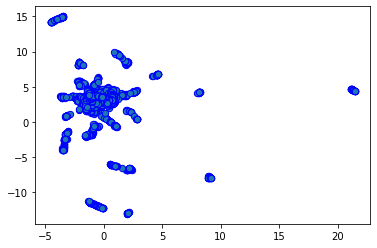

In [159]:
fig, ax = plt.subplots()
ax.scatter(X_w_u[:, 0], X_w_u[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()


In [160]:
umap_w = umap.UMAP()
X2_w_u = umap_w.fit_transform(X2_w)

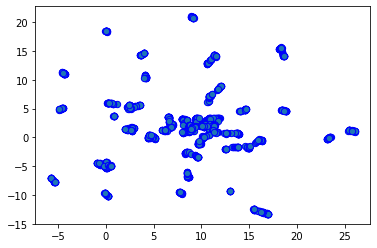

In [161]:
fig, ax = plt.subplots()
ax.scatter(X2_w_u[:, 0], X2_w_u[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=40)
plt.show()


Теперь поговорим об алгоритме Expectation Maximization. 

Но сперва придется разобраться с методом максимального правдоподобия. Этот метод получает на вход некоторое распределение, принадлежащее некоторому множеству распределений, а также само это множество. Считается, что все распределения, входящие в множество, подчинены какой-то неявной закономерности, в рамках которой какие-то распределения являются более вероятными, а какие-то менее (обладают большим или меньшим правдоподобием). Метод оценивает насколько данное распределение является правдоподобным в рамках имеющегося множества распределений. 

Пример метода максимального правдоподобия и его разбор можно найти [здесь](https://habr.com/ru/companies/otus/articles/585610/).

Сходные задачи решает метод [перплексии](https://habr.com/ru/companies/wunderfund/articles/580230/), который показывает, насколько "неожиданным" является очередной элемент в системе.

Теперь представим себе, что мы моделируем поведение неявной системы, которая порождает некоторые распределения. Мы можем проинициализровать параметры такой системы случайным образом, так как не знаем какими они должны быть. Теперь мы можем взять распределения, которые получаются у моделируемой системы и определить, насколько они правдоподобны для нашей моделирующей системы. Если правдоподобие оказывается низким, то нам необходимо поменять параметры моделирующей системы, чтобы правдоподобие стало выше. Фактически мы решаем задачу оптимизации для функции оценки правдоподобия.

Именно этим занимается метод [Expectation](https://habr.com/ru/articles/501850/) [Maximization](http://www.machinelearning.ru/wiki/index.php?title=EM-%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC). 

Предположим, что тексты разбиваются по некоторым тематикам. Для каждой тематики можно задать центр, а тексты данной тематики будут распределены по нормальному закону от этого центра. Используем для их обнаружения класс [GaussianMixture из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture).

In [162]:
from sklearn.mixture import GaussianMixture

К сожалению, он не умеет работать с разреженными матрицами, а для построения плотную мне не хватает оперативной памяти.

In [200]:
X_w.shape

(1446, 24594)

In [163]:
gm = GaussianMixture(n_components=10)
gm_res = gm.fit(X_w.toarray())
gm_res.aic(X_w.toarray())

MemoryError: Unable to allocate 45.1 GiB for an array with shape (10, 24594, 24594) and data type float64

Построим разное количество компонент и оценим их правдоподобие по Акайке.

In [164]:
gm2 = GaussianMixture(n_components=10)
gm2_res = gm2.fit(X2_w)
gm2_res.aic(X2_w)

-176545.35623897405

In [165]:
gm2 = GaussianMixture(n_components=2)
gm2_res = gm2.fit(X2_w)
gm2_res.aic(X2_w)

-92253.23922519958

In [166]:
gm2 = GaussianMixture(n_components=16)
gm2_res = gm2.fit(X2_w)
gm2_res.aic(X2_w)

-191470.56050164043

Используем метод k-средних, чтобы он определил какой текст ближе к какому центроиду. На самом деле, это очень грубое приближение, так как он пытается строить сферы. Метод Гаусовских смесей при этом может выделять направления и обладать разной дисперсией в разных направлениях. Но для первого приближения - пойдет.

In [84]:
from sklearn.cluster import KMeans

In [167]:
km = KMeans(n_clusters=16, init=gm2_res.means_)
km.cluster_centers_ = gm2_res.means_
km._n_threads = 4

In [168]:
y_hat = km.predict(X2_w)

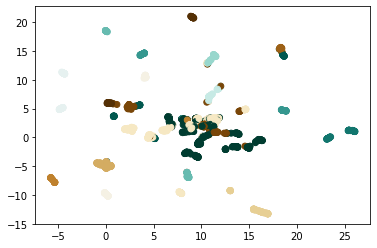

In [169]:
fig, ax = plt.subplots()
ax.scatter(X2_w_u[:, 0], X2_w_u[:, 1], 
           cmap=plt.cm.BrBG, c=y_hat)
plt.show()


In [170]:
y_hat[:10]

array([6, 6, 6, 6, 6, 1, 6, 6, 6, 6], dtype=int32)

Посмотрим как группируются тексты сводок.

In [171]:
[(y, sum([1 for x in y_hat if x == y])) for y in range(max(y_hat)+1)]

[(0, 60),
 (1, 128),
 (2, 31),
 (3, 26),
 (4, 65),
 (5, 65),
 (6, 247),
 (7, 54),
 (8, 54),
 (9, 53),
 (10, 39),
 (11, 54),
 (12, 56),
 (13, 61),
 (14, 53),
 (15, 400)]

In [203]:
coi = 15

cnt = 0
for n, c in zip(newws, y_hat):
    if c == coi:
        print(n[:300], '\n=====\n')
        cnt += 1
        if cnt == 5:
            break


Войска 1-го УКРАИНСКОГО фронта, после длительной осады и упорных боёв завершили ликвидацию окружённого гарнизона противника и 1 апреля овладели городом и крепостью ГЛОГАУ (ГЛОГУВ) - мощным узлом обороны немцев на левом берегу ОДЕРА.

В ходе боёв за ГЛОГАУ войска фронта взяли в плен более 8.000 неме 
=====


В течение 2 апреля на БРАТИСЛАВСКОМ направлении войска 2-го УКРАИНСКОГО фронта, продолжая наступление, овладели городом и железнодорожной станцией ТОПОЛЬЧАНЫ, а также заняли более 100 других населённых пунктов, в числе которых крупные населённые пункты БОШАНЫ, ВЕЛКИ РИПНЯНЫ, СИЛАДИЦЕ, СУХА, ПУДМЕРИ 
=====


13 течение 3 апреля войска 2-го БЕЛОРУССКОГО фронта вели бои по уничтожению остатков окружённой группы немецких войск восточнее ГДАНЬСКА и заняли населённые пункты НОЙЕНДОРФ, КЛАЙНПЛЕНЕДОРФ, ЗИГЕСКРАНЦ, ХОЙБУДЕ, КРАКАУЕРКЕМПЕ, КРАКАУ. За 1 и 2 апреля в этом районе взято в плен более 2.000 немецких  
=====


В течение 4 апреля в полосе Карпат, юго-западнее города НОВЫ ТАРГ, войск

Ну, побаловались и хватит. Попросим само Гаусовское распределение расклассифицировать имеющиеся у нас тексты.

In [177]:
y_hat = gm2.predict(X2_w)

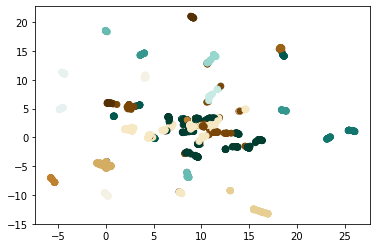

In [178]:
fig, ax = plt.subplots()
ax.scatter(X2_w_u[:, 0], X2_w_u[:, 1], 
           cmap=plt.cm.BrBG, c=y_hat)
plt.show()


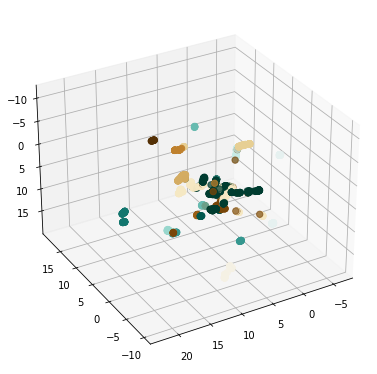

In [199]:
umap_w = umap.UMAP(n_components=3)
X3_w_u = umap_w.fit_transform(X2_w)

%matplotlib inline

fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig, auto_add_to_figure=False, elev=-150, azim=120)
fig.add_axes(ax)
ax.scatter(X3_w_u[:, 0], X3_w_u[:, 1], X3_w_u[:, 2], c=y_hat,
          cmap=plt.cm.BrBG, s=40);


Распределение в итоге оказывается похожее, но другое. Посмотрим как группируются тексты сводок в исходном методе.

In [179]:
[(y, sum([1 for x in y_hat if x == y])) for y in range(max(y_hat)+1)]

[(0, 60),
 (1, 145),
 (2, 31),
 (3, 26),
 (4, 65),
 (5, 65),
 (6, 275),
 (7, 54),
 (8, 54),
 (9, 54),
 (10, 41),
 (11, 54),
 (12, 56),
 (13, 61),
 (14, 56),
 (15, 349)]

In [180]:
coi = 6

cnt = 0
for n, c in zip(newws, y_hat):
    if c == coi:
        print(n[:300], '\n=====\n')
        cnt += 1
        if cnt == 5:
            break


В последний час

На ЦЕНТРАЛЬНОМ фронте наши войска в результате решительного штурма овладели городом и железнодорожным узлом ВЕЛИКИЕ ЛУКИ. Ввиду отказа сложить оружие немецкий гарнизон города истреблён.

Южнее СТАЛИНГРАДА наши войска овладели городом ЭЛИСТА.

Юго-западнее Сталинграда наши войска ов 
=====


Утреннее сообщение 2 января

В течение ночи на 2 января наши войска в районе Среднего Дона, юго-западнее и южнее Сталинграда, на Центральном фронте и на Северном Кавказе продолжали вести наступательные бои на прежних направлениях.

Вечернее сообщение 2 января

В течение 2 января наши войска в район 
=====


В последний час

3 января наши наступающие войска внезапным ударом овладели городом и железнодорожной станцией МОЗДОК, а также городом МАЛГОБЕК.

Утреннее сообщение 3 января

В течение ночи на 3 января наши войска в районе Среднего Дона, юго-западнее и южнее Сталинграда, на Центральном фронте и на  
=====


В последний час

4 января наши наступающие войска овладели городом ЧЕРНЫ